In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib2
% matplotlib inline

In [2]:
date = "150808" ## LATER: update to pull most recent week or take an argument
url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_" + date + ".txt"
data = urllib2.urlopen(url)
df = pd.read_csv(data)

In [3]:
df.head()

## it works!!

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,08/01/2015,00:00:00,REGULAR,5249369,1775966
1,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,08/01/2015,04:00:00,REGULAR,5249393,1775968
2,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,08/01/2015,08:00:00,REGULAR,5249415,1775987
3,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,08/01/2015,12:00:00,REGULAR,5249519,1776069
4,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,08/01/2015,16:00:00,REGULAR,5249751,1776111


In [4]:
## check for irregular rows

irreg = sum(df.DESC != "REGULAR")

recoverd = sum(df.DESC == "RECOVR AUD")

## verify that all irregular rows are "recovered audits"
assert(irreg == recoverd)

In [5]:
## filter out PATH trains (DIVISION = "PTH")
lenbefore = len(df)
df2 = df[df.DIVISION != "PTH"]
lenafter = len(df2)

assert(lenbefore > lenafter)
assert(sum(df2.DIVISION == "PTH") == 0)
df = df2

In [6]:
## aggregate by station (we don't care about individual devices)
##  while preserving date/time data

## GROUP_BY station, linename, date, time AGGREGATE entries, exits BY sum
aggdf = df.groupby(["STATION","LINENAME","DATE","TIME"]).sum()
aggdf.head(100)
## some stations share a name, but no stations on the same line share a name, thus use of both STATION and LINENAME
##  (some stations also have multiple UNITs)

ENTRIES  \
STATION LINENAME DATE       TIME                   
1 AVE   L        08/01/2015 00:00:00  1404469489   
                            04:00:00  1404471670   
                            08:00:00  1404472343   
                            12:00:00  1404475276   
                            16:00:00  1404480057   
                            20:00:00  1404484778   
                 08/02/2015 00:00:00  1404488579   
                            04:00:00  1404490267   
                            08:00:00  1404490794   
                            12:00:00  1404493120   
                            16:00:00  1404496916   
                            20:00:00  1404500584   
                 08/03/2015 00:00:00  1404503304   
                            04:00:00  1404503858   
                            08:00:00  1404505629   
                            12:00:00  1404510784   
                            16:00:00  1404514302   
                            20:00:00  1404520569   
                 08/04/2015 00:00:00  1404524191   
                            04:00:00  1404524862   
                            08:00:00  1404526624   
                            12:00:00  1404531697   
                            16:00:00  1404535600   
                            20:00:00  1404542171   
                 08/05/2015 00:00:00  1404546371   
                            04:00:00  1404547193   
                            08:00:00  1404548971   
                            12:00:00  1404554367   
                            16:00:00  1404558426   
                            20:00:00  1404565044   
...                                          ...   
103 ST  1        08/05/2015 17:00:00    61883358   
                            21:00:00    61886083   
                 08/06/2015 01:00:00    61886965   
                            05:00:00    61887033   
                            09:00:00    50062150   
                            13:00:00    61893264   
                            17:00:00    61895942   
                            21:00:00    61898781   
                 08/07/2015 01:00:00    61899804   
                            05:00:00    61899873   
                            09:00:00    61902507   
                            13:00:00    61905714   
                            17:00:00    61908393   
                            21:00:00    61911097   
        6        08/01/2015 01:00:00    37022891   
                            05:00:00    37023002   
                            09:00:00    37023551   
                            13:00:00    37024717   
                            17:00:00    37025988   
                            21:00:00    37026969   
                 08/02/2015 01:00:00    37027473   
                            05:00:00    37027578   
                            09:00:00    37027993   
                            13:00:00    37028763   
                            17:00:00    37029782   
                            21:00:00    37030668   
                 08/03/2015 01:00:00    37031009   
                            05:00:00    37031087   
                            09:00:00    37032363   
                            13:00:00    37033766   

                                      EXITS                                                                 
STATION LINENAME DATE       TIME                                                                            
1 AVE   L        08/01/2015 00:00:00                                         1465927127                     
                            04:00:00                                         1465928311                     
                            08:00:00                                         1465929324                     
                            12:00:00                                         1465931908                     
                            16:00:00                                         1465935943                     
 

In [7]:
## some rows are missing -- 103rd St 1 line 8/6/2015 at 9:00am reading missing.
##  how do we identify more such rows?
##    after subtracting prv row value, these rows should be the only ones with negative values
##  how do we fix them?
##    a. remove row entirely (won't someone PLEASE think of the DATA!!)
##    b. interpolate (split the diff btwn next and previous rows) (ideal, but futzier)
##    c. subtract cumulative totals before agg'ing (missing entries will accrue to next row) (easier to implement)

## subtract previous row values for all entries and exits to get total during period
agg = df.groupby(["UNIT", "SCP", "STATION","LINENAME"])
obj = pd.DataFrame()
for name, group in agg:
    #print name
    group = group.reset_index(drop=True)
    #print group.values[0]
    nc_ent = [0]
    nc_ext = [0]
    for i in range(1,len(group)):
        nc_ent.append(group.values[i][9]-group.values[i-1][9])
        nc_ext.append(group.values[i][10]-group.values[i-1][10])
    out = pd.concat([group,
                     pd.Series(nc_ent,name="NC_ENTRIES"),
                     pd.Series(nc_ext,name="NC_EXITS")], axis=1)
    obj = pd.concat([obj,out],ignore_index=True)

In [8]:

## Check for negative values

obj[obj.NC_ENTRIES < 0]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,NC_ENTRIES,NC_EXITS
2185,J034,R007,00-00-02,104 ST,JZ,BMT,08/01/2015,04:00:00,REGULAR,2026228302,622270628,-7,-9
2186,J034,R007,00-00-02,104 ST,JZ,BMT,08/01/2015,08:00:00,REGULAR,2026228264,622270614,-38,-14
2187,J034,R007,00-00-02,104 ST,JZ,BMT,08/01/2015,12:00:00,REGULAR,2026228205,622270602,-59,-12
2188,J034,R007,00-00-02,104 ST,JZ,BMT,08/01/2015,16:00:00,REGULAR,2026228156,622270562,-49,-40
2189,J034,R007,00-00-02,104 ST,JZ,BMT,08/01/2015,20:00:00,REGULAR,2026228119,622270516,-37,-46
2190,J034,R007,00-00-02,104 ST,JZ,BMT,08/02/2015,00:00:00,REGULAR,2026228100,622270481,-19,-35
2191,J034,R007,00-00-02,104 ST,JZ,BMT,08/02/2015,04:00:00,REGULAR,2026228096,622270466,-4,-15
2192,J034,R007,00-00-02,104 ST,JZ,BMT,08/02/2015,08:00:00,REGULAR,2026228077,622270456,-19,-10
2193,J034,R007,00-00-02,104 ST,JZ,BMT,08/02/2015,12:00:00,REGULAR,2026228020,622270439,-57,-17
2194,J034,R007,00-00-02,104 ST,JZ,BMT,08/02/2015,16:00:00,REGULAR,2026227985,622270406,-35,-33


In [9]:
print sum(obj.NC_ENTRIES < 0)
print sum(obj.NC_ENTRIES < 0) / 42 ## 7 days * 6 collections per day = 42 entries for each device

## Several of the devices appear to be counting down rather than up. (1145 total negative records; ~ 27 devices)
##  It could be that their data is completely erroneous but I find that unlikely given that
##  the magnitudes in the daily patterns they report are sync with other (non-faulty) devices.
## Solutions?
##  a. identify each such device and multiply their figures by -1 (differences should remain constant)
##  b. remove from dataset entirely (my precious data!)
##  c. take absolute value for all entries

## solution C
##  assumes that all devices malfunctioned in the same, acceptable way. simply counting down instead of up.
##  if there are some extreme values (10K+ for instance) we will catch them further downstream

obj.NC_ENTRIES = abs(obj.NC_ENTRIES)
obj.NC_EXITS = abs(obj.NC_EXITS)

obj.describe()

1145
27


,ENTRIES,EXITS,NC_ENTRIES,NC_EXITS
count,1.800060e+05,1.800060e+05,1.800060e+05,1.800060e+05
mean,3.288954e+07,2.706664e+07,1.749209e+04,6.053165e+03
std,1.882045e+08,1.712966e+08,4.566093e+06,2.132906e+06
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.425530e+05,3.498950e+05,1.200000e+01,9.000000e+00
50%,2.656890e+06,1.605210e+06,8.300000e+01,5.600000e+01
75%,6.413629e+06,4.654803e+06,2.570000e+02,1.740000e+02
max,2.118720e+09,2.087387e+09,1.504094e+09,9.024604e+08


In [10]:
## some show over 10^9 entries during a given hour. this seems unlikely. let's take a look.

obj[obj.NC_ENTRIES > 5000]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,NC_ENTRIES,NC_EXITS
17695,N505,R022,02-06-01,34 ST-HERALD SQ,BDFMNQR,IND,08/02/2015,16:00:00,REGULAR,117440596,77,114496385,1009581
19179,N606,R025,00-00-00,JAMAICA CENTER,EJZ,IND,08/04/2015,08:00:00,REGULAR,374,439,4124407,28340313
19221,N606,R025,00-00-01,JAMAICA CENTER,EJZ,IND,08/04/2015,12:00:00,REGULAR,1207432441,1323,1205255819,7855784
42412,R610,R057,00-03-05,BARCLAYS CENTER,2345BDNQR,IRT,08/05/2015,12:00:00,REGULAR,2111,34,16860,1785
85808,N120A,R153,01-05-00,UTICA AVE,AC,IND,08/02/2015,13:00:00,REGULAR,50331653,16777216,50330302,16777216
86818,N222,R156,00-00-00,BEDFORD PARK BL,BD,IND,08/01/2015,21:00:00,REGULAR,2130,120,5082540,4633417
86899,N222,R156,00-00-02,BEDFORD PARK BL,BD,IND,08/01/2015,17:00:00,REGULAR,92,126,5527319,5061931
86940,N222,R156,00-00-03,BEDFORD PARK BL,BD,IND,08/01/2015,21:00:00,REGULAR,41,39,5275871,4568297
100114,R247,R178,01-00-03,77 ST,6,IRT,08/07/2015,17:00:00,REGULAR,210,300,1979451,7991734
100199,R247,R178,01-03-01,77 ST,6,IRT,08/07/2015,13:00:00,REGULAR,54,191,3714585,25171275


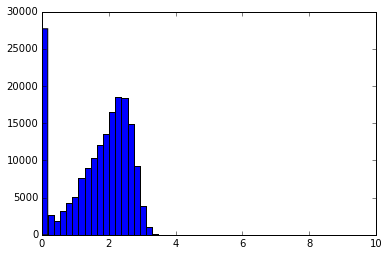

In [11]:
## Let's make a histogram to see where we should make the cut

entrynums = obj.NC_ENTRIES.copy() ## avoid tampering with the dataset unless necessary

entrynums += 1 ## add 1 to all (since we need to take log, cannot have zeros. 
               ##               this is a quick solution that does not compromise the histogram)

plt.hist(np.log10(entrynums),bins=50)
plt.show()

In [12]:
## Neat!! well, it looks like anything over a power of 4 (10,000) is an extreme outlier and most likely bad data.
##  In fact, we can look at the data and determine that anything above 5k can be dropped.
##    (closest legit data is ~3k from Grand Central)
##    this knocks out 19 readings out of about 180K (not bad)

ndf = obj[obj.NC_ENTRIES < 5000]

In [13]:
ndf.describe()

,ENTRIES,EXITS,NC_ENTRIES,NC_EXITS
count,1.799870e+05,1.799870e+05,179987.000000,179987.000000
mean,3.287540e+07,2.706409e+07,184.636396,141.689589
std,1.881612e+08,1.712929e+08,260.233661,233.219676
min,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,6.427545e+05,3.500425e+05,12.000000,9.000000
50%,2.656949e+06,1.605755e+06,83.000000,56.000000
75%,6.413418e+06,4.654835e+06,257.000000,174.000000
max,2.118720e+09,2.087387e+09,3366.000000,5197.000000


In [14]:
## we should do the same with exits, however maximum number of exits is 5197, which seems reasonable
##  let's just check to make sure it is a time/station for which that may be plausible.

ndf[ndf.NC_EXITS > 5000]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,NC_ENTRIES,NC_EXITS
36397,R241A,R048,00-00-00,42 ST-GRD CNTRL,4567S,IRT,08/06/2015,13:00:00,REGULAR,12959071,25997628,230,5197


In [15]:
## again it's grand central, this time at the morning rush hour. This makeA.

In [23]:
## Next let's explore the data a bit:
##  Step 1: Aggregate the data by station to compare ridership at different stops
##           and different lines
##  Step 2: Aggregate all stations by day/time to visualize daily/weekly patterns

## Step 1

## First let's make the station names unique by appending the linename to them. 
##  Not necessarily pretty but effective.

comparison_set = ndf.copy()
## Always use a copy! don't alter the original dataset in case we want to use it to do something else later
##   Also useful for prototyping when we go back and make revisions, we want to start from scratch each time
##    not build off previous mistakes or need to correct them first

comparison_set.STATION = comparison_set.STATION + " " + comparison_set.LINENAME

comparison_set.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,NC_ENTRIES,NC_EXITS
0,A060,R001,00-00-00,WHITEHALL ST R1,R1,BMT,08/01/2015,01:00:00,REGULAR,1382501,1487997,0,0
1,A060,R001,00-00-00,WHITEHALL ST R1,R1,BMT,08/01/2015,05:00:00,REGULAR,1382547,1488022,46,25
2,A060,R001,00-00-00,WHITEHALL ST R1,R1,BMT,08/01/2015,09:00:00,REGULAR,1382761,1488055,214,33
3,A060,R001,00-00-00,WHITEHALL ST R1,R1,BMT,08/01/2015,13:00:00,REGULAR,1383125,1488228,364,173
4,A060,R001,00-00-00,WHITEHALL ST R1,R1,BMT,08/01/2015,17:00:00,REGULAR,1383743,1488414,618,186


In [36]:
## now let's group by station to compare raw figures for the whole week

compare_stations = comparison_set.groupby("STATION").sum()

# Entries
print compare_stations.sort("NC_ENTRIES",ascending=False).head(15).NC_ENTRIES ## top subway stations
print compare_stations.sort("NC_ENTRIES",ascending=True).head(15).NC_ENTRIES ## bottom subway stations

# Exits
print compare_stations.sort("NC_EXITS",ascending=False).head(15).NC_EXITS ## top subway stations
print compare_stations.sort("NC_EXITS",ascending=True).head(15).NC_EXITS ## bottom subway stations

STATION
42 ST-GRD CNTRL 4567S          902996
34 ST-HERALD SQ BDFMNQR        752262
42 ST-TIMES SQ 1237ACENQRS     579636
42 ST-PA BUS TE ACENQRS1237    572961
34 ST-PENN STA ACE             506108
14 ST-UNION SQ LNQR456         442379
86 ST 456                      382937
MAIN ST 7                      375525
47-50 ST-ROCK BDFM             346750
34 ST-PENN STA 123ACE          335972
59 ST-COLUMBUS ABCD1           325093
ROOSEVELT AVE EFMR7            312108
CANAL ST JNQRZ6                300912
59 ST 456NQR                   293258
W 4 ST-WASH SQ ABCDEFM         258517
Name: NC_ENTRIES, dtype: int64
STATION
34 ST-HUDSON YD 7      29
BROAD CHANNEL AS     2187
BEACH 105 ST AS      3520
BEACH 44 ST A        4091
TOMPKINSVILLE 1      4567
ORCHARD BEACH 6      5128
ROCKAWAY BLVD A      5697
E 143 ST 6           5730
BEACH 36 ST A        6032
AVE X F              7138
AQUEDUCT-N CNDT A    8071
CYPRESS HILLS J      8200
BEACH 98 ST AS       8275
DITMAS AVE F         8475
22 AVE-BAY PKY F   

In [82]:
## This conforms to our expectations about which subway stations should have the most traffic
##  It's interesting to note, though, that most of the big ones get more entries than exits.
##   If we assume most traffic is from commuters, everyone who exits there in the morning 
##    will also enter there in the evening. Perhaps the devices miss the "exit only" turnstiles.
##   Otherwise there must be a reason for many people get to the vicinity of a station by a means other 
##    than subway then leave by subway (getting marked as an entry, with no corresponding exit)
##   For places like GC and Penn Station, those could be train riders. But again, most train riders eventually
##    make a return trip

## Well, great, let's keep going then. Let's compare lines.
##  First we need to split up the "LINENAME" column.
##  Ideally what we want is for each STATION with multiple lines to have 
##   multiple rows with a single line in the LINENAME

## Then let's consider our numbers. For stations with multiple lines, we can either count all entries for all lines
##  (overestimate) or we can divide by the number of lines (assumes each line is equally popular at each station)

##  While neither can help us reconstruct which lines passengers ACTUALLY took, we will go for the second one
##   this also avoids double-counting trips.

## To do this we need to iterate through each station, create a row per line in that station, and divide the totals
##  by the number of lines at the station

KeyboardInterrupt: 

In [88]:
# single line stations return each row with no changes
# multi line stations return a row for each line in the original row
# multi line stations' line

def row_processor(row):
    lines = row.loc["LINENAME"]
    num_lines = len(lines)
    row["LINE_ENTRIES"] = row.NC_ENTRIES/num_lines
    row["LINE_EXITS"] = row.NC_EXITS/num_lines
    rows = []
    for line in lines:
        row.LINENAME = line
        rows.append(row.copy())  #always use a copy!
    return rows

new_rows = [] 
for index, row in comparison_set.copy().iterrows():
    new_rows.extend(row_processor(row))
    if index % 1000 == 0:  ## for convenience to track progress (takes a couple minutes to run)
        print index
line_compare = pd.concat(new_rows,axis=1,ignore_index=True)
line_compare.transpose().tail(20)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,NC_ENTRIES,NC_EXITS,LINE_ENTRIES,LINE_EXITS
488922,JFK03,R536,00-03-04,JFK JAMAICA CT1 E,E,IND,08/04/2015,13:00:00,REGULAR,7727,17301,82,53,82,53
488923,JFK03,R536,00-03-04,JFK JAMAICA CT1 E,E,IND,08/04/2015,17:00:00,REGULAR,7805,17418,78,117,78,117
488924,JFK03,R536,00-03-04,JFK JAMAICA CT1 E,E,IND,08/04/2015,21:00:00,REGULAR,7953,17680,148,262,148,262
488925,JFK03,R536,00-03-04,JFK JAMAICA CT1 E,E,IND,08/04/2015,22:31:51,RECOVR AUD,7985,17785,32,105,32,105
488926,JFK03,R536,00-03-04,JFK JAMAICA CT1 E,E,IND,08/05/2015,01:00:00,REGULAR,8004,17846,19,61,19,61
488927,JFK03,R536,00-03-04,JFK JAMAICA CT1 E,E,IND,08/05/2015,05:00:00,REGULAR,8017,17877,13,31,13,31
488928,JFK03,R536,00-03-04,JFK JAMAICA CT1 E,E,IND,08/05/2015,09:00:00,REGULAR,8097,17999,80,122,80,122
488929,JFK03,R536,00-03-04,JFK JAMAICA CT1 E,E,IND,08/05/2015,13:00:00,REGULAR,8244,18182,147,183,147,183
488930,JFK03,R536,00-03-04,JFK JAMAICA CT1 E,E,IND,08/05/2015,17:00:00,REGULAR,8395,18420,151,238,151,238
488931,JFK03,R536,00-03-04,JFK JAMAICA CT1 E,E,IND,08/05/2015,21:00:00,REGULAR,8579,18688,184,268,184,268


In [90]:
line_compare = line_compare.transpose()

In [91]:
line_compare.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,NC_ENTRIES,NC_EXITS,LINE_ENTRIES,LINE_EXITS
0,A060,R001,00-00-00,WHITEHALL ST R1,R,BMT,08/01/2015,01:00:00,REGULAR,1382501,1487997,0,0,0,0
1,A060,R001,00-00-00,WHITEHALL ST R1,1,BMT,08/01/2015,01:00:00,REGULAR,1382501,1487997,0,0,0,0
2,A060,R001,00-00-00,WHITEHALL ST R1,R,BMT,08/01/2015,05:00:00,REGULAR,1382547,1488022,46,25,23,12
3,A060,R001,00-00-00,WHITEHALL ST R1,1,BMT,08/01/2015,05:00:00,REGULAR,1382547,1488022,46,25,23,12
4,A060,R001,00-00-00,WHITEHALL ST R1,R,BMT,08/01/2015,09:00:00,REGULAR,1382761,1488055,214,33,107,16


In [93]:
## Perfect! now we can aggregate by line

compare_lines = line_compare.groupby("LINENAME").sum()

print compare_lines.sort("LINE_ENTRIES",ascending=False).head(15).LINE_ENTRIES ## top subway lines
print compare_lines.sort("LINE_ENTRIES",ascending=True).head(15).LINE_ENTRIES ## bottom subway lines

print compare_lines.sort("LINE_EXITS",ascending=False).head(15).LINE_EXITS ## top subway lines
print compare_lines.sort("LINE_EXITS",ascending=True).head(15).LINE_EXITS ## bottom subway lines


LINENAME
6           2912037
1           2670595
R           2078586
F           1957331
7           1952341
C           1735304
A           1713658
4           1627935
2           1563257
5           1536001
B           1510165
N           1490340
M           1404834
D           1397137
E           1376726
Name: LINE_ENTRIES, dtype: int64
LINENAME
S            378738
Z            497536
G            623621
J            694438
L           1277222
Q           1331955
3           1369138
E           1376726
D           1397137
M           1404834
N           1490340
B           1510165
5           1536001
2           1563257
4           1627935
Name: LINE_ENTRIES, dtype: int64
LINENAME
6           2457811
1           1959629
7           1643877
F           1501263
R           1459547
C           1276855
A           1276276
N           1228539
4           1228153
B           1173033
5           1149280
E           1133754
M           1111200
2           1107461
Q           1064161
Name: L